In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -uq '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/train.zip'
!unzip -uq '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/test.zip'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# We unzip the train and test zip file
train = ZipFile("/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/train.zip", 'r')
test = ZipFile("/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/test.zip", 'r')
# This line shows the 5 first image name of the train database
train.namelist()[0:5]
# This line shows the number of images in the train database, noted that we must remove the 1st value (column header)
len(train.namelist()[:]) - 1

10222

In [0]:
# This function help to create a pickle file gathering all the image from a zip folder
def DataBase_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # nwidth x nheight = number of features because images have nwidth x nheight pixels
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3)
    allImage = np.zeros(s)
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allImage[i-1]=image
    
    # we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [0]:
# Define the new image size applied for all images
# Create a pickle file for both the training and desting dataset
image_resize = 60
DataBase_creator(archivezip = train, nwidth = image_resize, 
                 nheight = image_resize , save_name = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/train")
# DataBase_creator(archivezip = test, nwidth = image_resize, 
#                  nheight = image_resize , save_name = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/test")

Time usage: 0:00:38


In [0]:
# load train pickle file
train = pickle.load( open( "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/train.p", "rb" ) )
train.shape

(10222, 60, 60, 3)

In [0]:
# load test pickle file
test = pickle.load( open( "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/pickle/test.p", "rb" ) )
test.shape

(10357, 60, 60, 3)

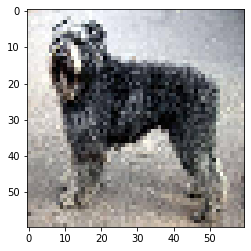

In [0]:
plt.imshow(test[100,:,:,:])

In [0]:
# reading in labels
path = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/labels.csv"
labels = pd.read_csv(path)

In [0]:
# normalizing the images
image_resize = 60
nwidth = image_resize
nheight = image_resize

# nwidth x nheight = number of features because images are nwidth x nheight pixels
s = (len(labels['breed']), nwidth, nheight,3) 
allImage = np.zeros(s)

i = 0
for f, breed in labels.values:
    image = PIL.Image.open('../content/train/{}.jpg'.format(f))
    image = image.resize((nwidth, nheight))
    image = np.array(image)
    image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
    i += 1
    allImage[i-1]=image

    train = allImage

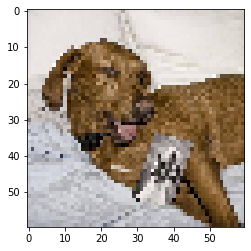

In [0]:

plt.imshow(train[100,:,:,:])
plt.show()

In [0]:
labels.sample(5)

,id,breed
9925,f97b9b8848683ab240cffeda2c855502,entlebucher
409,09d462e2ad4d8c51d1a8430577891d8a,irish_terrier
2497,3e2f226678909037ed26abc9c2289af9,black-and-tan_coonhound
8427,d3ab6b3d328b2cd91bed99aee99fa6ed,kuvasz
7885,c552deb03796d5f050d9d2cfd1323d73,brabancon_griffon


In [0]:
labels["breed"]

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [0]:
# Get the N most represented breeds
def main_breeds(labelsRaw, numBreeds , allBreeds='TRUE'):
    labels_freq_pd = itemfreq(labelsRaw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]
    
    if allBreeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:numBreeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labelsRaw["breed"].as_matrix()
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)
    labels_filtered_index = np.where(labels_raw_np == main_labels)
    return labels_filtered_index

In [0]:
breeds = 10
labels_filtered_index = main_breeds(labelsRaw = labels, numBreeds = breeds, allBreeds='FALSE')
labels_filtered = labels.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]
print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 10 main breeds : (1141,)
- The shape of train_filtered dataset is : (1141, 60, 60, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(1141, 1)

In [0]:
# Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [0]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 10
Shape : (1141, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [0]:
for breed in range(len(labels_name)):
   print('Breed {0} : {1}'.format(breed,labels_name[breed]))

Breed 0 : afghan_hound
Breed 1 : basenji
Breed 2 : bernese_mountain_dog
Breed 3 : entlebucher
Breed 4 : great_pyrenees
Breed 5 : maltese_dog
Breed 6 : pomeranian
Breed 7 : samoyed
Breed 8 : scottish_deerhound
Breed 9 : shih-tzu


In [0]:
labels_cls = np.argmax(labels_bin, axis=1)
labels[0:9]

array([['basenji'],
       ['scottish_deerhound'],
       ['maltese_dog'],
       ['shih-tzu'],
       ['samoyed'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog']], dtype=object)

In [0]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)

In [0]:
# split original data to train and test sets
def train_test_creation(x, data, toPred): 
  indices = sample(range(data.shape[0]),int(x * data.shape[0])) 
  indices = np.sort(indices, axis=None) 
  
  index = np.arange(data.shape[0]) 
  reverse_index = np.delete(index, indices,0)
  
  train_toUse = data[indices]
  train_toPred = toPred[indices]
  test_toUse = data[reverse_index]
  test_toPred = toPred[reverse_index]

  return train_toUse, train_toPred, test_toUse, test_toPred

df_train_toUse, df_train_toPred, df_test_toUse, df_test_toPred = train_test_creation(0.7, train_filtered, labels_bin)

df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([6, 4, 7, 2, 6, 9, 1, 1, 8])

In [0]:
# The 100 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 5 breeds
num_classes = breeds

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #outputs the constant value 0.05

In [0]:
# definte convolutional layer
def conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [0]:
# definte flatten layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [0]:
# define fully connected layer
def fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [0]:
# setting up placeholder tensor
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.


# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 64      # There are 64 of these filters.


# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 128      # There are 128 of these filters.


# Fully-connected layer.
fc_size = 500 

layer_conv1, weights_conv1 = \
    conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)

#Train
layer_fc1 = fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc2 = fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

#Prediction
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [0]:
# defining loss function to train the model
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# train the network
session = tf.Session()
def init_variables():
   session.run(tf.global_variables_initializer())

In [0]:
# creates a batch from a dataset
# the batch is used to train the model

batch_size = 50

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]


    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)


            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()


    # Difference between start and end-times.
    time_dif = end_time - start_time


    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

Iteration:    250, Training Accuracy:  24.0%, Validation Accuracy:  21.9%
Iteration:    500, Training Accuracy:  30.0%, Validation Accuracy:  28.6%
Iteration:    750, Training Accuracy:  54.0%, Validation Accuracy:  31.2%
Iteration:   1000, Training Accuracy:  56.0%, Validation Accuracy:  34.1%
Iteration:   1250, Training Accuracy:  56.0%, Validation Accuracy:  34.4%
Iteration:   1500, Training Accuracy:  68.0%, Validation Accuracy:  35.3%
Iteration:   1750, Training Accuracy:  60.0%, Validation Accuracy:  34.7%
Iteration:   2000, Training Accuracy:  74.0%, Validation Accuracy:  33.5%
Iteration:   2250, Training Accuracy:  90.0%, Validation Accuracy:  35.0%
Iteration:   2500, Training Accuracy:  90.0%, Validation Accuracy:  34.7%
Iteration:   2750, Training Accuracy:  84.0%, Validation Accuracy:  35.3%
Iteration:   3000, Training Accuracy:  92.0%, Validation Accuracy:  34.1%
Iteration:   3250, Training Accuracy:  88.0%, Validation Accuracy:  33.2%
Iteration:   3500, Training Accuracy: 

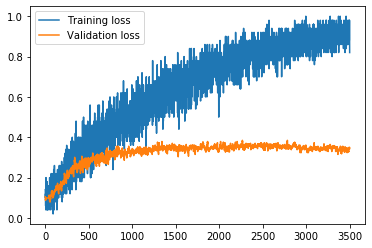

In [0]:
init_variables()
total_iterations = 0
optimize(num_iterations=3500, X=250)

The above model does not perform very well. It tends to overfit and isn't very good. The best validation accuracy was only 34.4%

### Transfer Learning


Using VGG16 model's convolutional base to extract features from the dog images to run through the classifier

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [0]:
train_dir = '/content/train/'
test_dir = '/content/test/'

In [0]:
# reading in labels
path = "/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog-breed-id/labels.csv"
labels = pd.read_csv(path)

# selecting only the top 10 classes of breeds
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(10).index)
labels = labels[labels['breed'].isin(selected_breed_list)]

labels['id'] = labels['id'] + '.jpg'
labels.head()

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9.jpg,basenji
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec.jpg,maltese_dog
57,0162b3e0144fb1d1ab82fbff3ace9938.jpg,shih-tzu
70,01b36cb1b80ab8c3a7d2b7128ad21bdc.jpg,samoyed


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )
train_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)
val_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)

Found 913 validated image filenames belonging to 10 classes.
Found 228 validated image filenames belonging to 10 classes.


In [0]:
train_generator

In [0]:
train = train_generator.image_data_generator
train
val = val_generator.image_data_generator
val

In [0]:
import keras
resnet = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.trainable=False

model = keras.Sequential([
    resnet, 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])

model.compile(
    optimizer='adam', 
    loss=keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [0]:
from keras.applications import VGG16

base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

base.summary()











Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

In [0]:
from keras.optimizers import Adam


opt = Adam(lr=0.001)
base.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [0]:
hist = model.fit_generator(steps_per_epoch=10,
                           generator=train_generator, validation_data= val_generator, 
                           validation_steps=10,epochs=10, shuffle=True)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.5571 - acc: 0.4758 - val_loss: 0.5427 - val_acc: 0.8288
Epoch 2/10
10/10 [==============================] - 6s 568ms/step - loss: 0.8514 - acc: 0.7156 - val_loss: 0.6832 - val_acc: 0.8014
Epoch 3/10
10/10 [==============================] - 6s 565ms/step - loss: 0.6928 - acc: 0.7625 - val_loss: 0.6004 - val_acc: 0.8733
Epoch 4/10
10/10 [==============================] - 6s 585ms/step - loss: 0.5083 - acc: 0.8125 - val_loss: 0.6543 - val_acc: 0.8447
Epoch 5/10
10/10 [==============================] - 6s 563ms/step - loss: 0.4937 - acc: 0.8217 - val_loss: 0.4374 - val_acc: 0.8801
Epoch 6/10
10/10 [==============================] - 6s 576ms/step - loss: 0.4232 - acc: 0.8625 - val_loss: 0.5851 - val_acc: 0.8596
Epoch 7/10
10/10 [==============================] - 6s 628ms/step - loss: 0.3031 - acc: 0.8969 - val_loss: 0.4319 - val_acc: 0.8801
Epoch 8/10
10/10 [==============================] - 6s 585ms/step - loss: 0.38

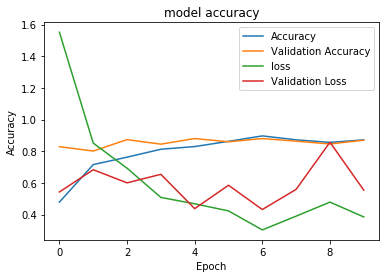

In [0]:

import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()